In [10]:
import torch
import matplotlib.pyplot as plt
from xopt import Xopt

In [11]:
# load base model and transformers
model = torch.load("./model/FELmodel_model.pt")
inputs_to_nn = torch.load("./model/input_transform.pt")
outputs_to_nn = torch.load("./model/output_transform.pt")

/lscratch/jmorgan/tmp/ipykernel_800493/547481811.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("./model/FELmodel_model.pt")
/lscratch/jmorgan/tmp/ip

In [12]:
model

Sequential(
  (0): Linear(in_features=7, out_features=248, bias=True)
  (1): ELU(alpha=1.0)
  (2): Linear(in_features=248, out_features=248, bias=True)
  (3): ELU(alpha=1.0)
  (4): Dropout(p=0.01, inplace=False)
  (5): Linear(in_features=248, out_features=248, bias=True)
  (6): ELU(alpha=1.0)
  (7): Linear(in_features=248, out_features=248, bias=True)
  (8): ELU(alpha=1.0)
  (9): Dropout(p=0.01, inplace=False)
  (10): Linear(in_features=248, out_features=248, bias=True)
  (11): ELU(alpha=1.0)
  (12): Linear(in_features=248, out_features=248, bias=True)
  (13): ELU(alpha=1.0)
  (14): Dropout(p=0.01, inplace=False)
  (15): Linear(in_features=248, out_features=4, bias=True)
)

In [13]:
# define transformed model class
class TransformedModel(torch.nn.Module):
    def __init__(self, model, input_transformer, output_transformer):
        super(TransformedModel, self).__init__()
        self.model = model
        self.input_transformer = input_transformer
        self.output_transformer = output_transformer
    
    def forward(self, x):
        x = self.input_transformer(x)
        x = self.model(x)
        x = self.output_transformer.untransform(x)
        return x

In [14]:
# create transformed model
transformed_model = TransformedModel(
    model=model, 
    input_transformer=inputs_to_nn,
    output_transformer=outputs_to_nn,
).to(torch.double)
transformed_model

TransformedModel(
  (model): Sequential(
    (0): Linear(in_features=7, out_features=248, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=248, out_features=248, bias=True)
    (3): ELU(alpha=1.0)
    (4): Dropout(p=0.01, inplace=False)
    (5): Linear(in_features=248, out_features=248, bias=True)
    (6): ELU(alpha=1.0)
    (7): Linear(in_features=248, out_features=248, bias=True)
    (8): ELU(alpha=1.0)
    (9): Dropout(p=0.01, inplace=False)
    (10): Linear(in_features=248, out_features=248, bias=True)
    (11): ELU(alpha=1.0)
    (12): Linear(in_features=248, out_features=248, bias=True)
    (13): ELU(alpha=1.0)
    (14): Dropout(p=0.01, inplace=False)
    (15): Linear(in_features=248, out_features=4, bias=True)
  )
  (input_transformer): AffineInputTransform()
  (output_transformer): AffineInputTransform()
)

In [15]:
import torch.nn.functional as F
# load example data and calculate predictions
inputs_small = torch.load("./info/test_model_inputs2.pt")
inputs_small = inputs_small.double()
outputs_small = torch.load("./info/test_model_outputs2.pt")
with torch.no_grad():
    predictions = transformed_model(inputs_small)




loss = F.mse_loss(outputs_to_nn(predictions), outputs_to_nn(outputs_small))
print("Loss:", loss.item())

loss = F.mse_loss((predictions),(outputs_small))
print("Loss unscaled:", loss.item())


#print(outputs_small)

Loss: 0.0028210837150193517
Loss unscaled: 45196.60081423089


/lscratch/jmorgan/tmp/ipykernel_800493/1373332218.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inputs_small = torch.load("./info/test_model_inputs2.pt")
/lscratch/jmo

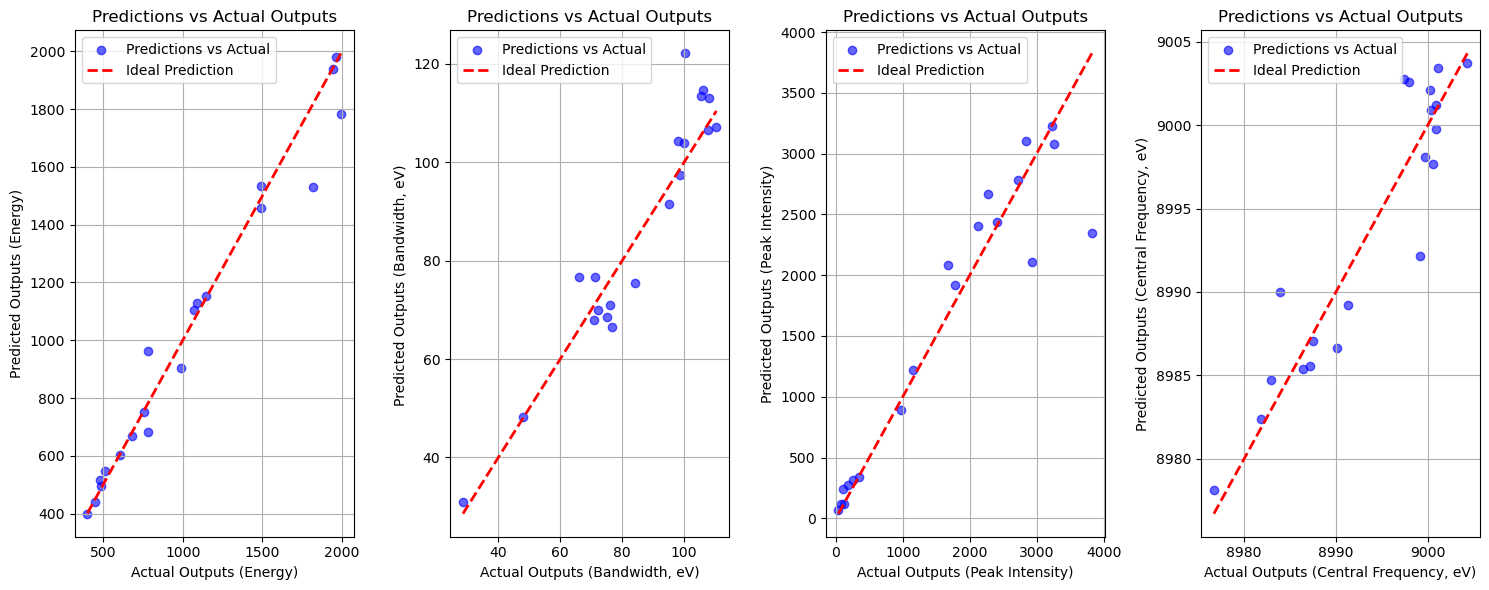

20

In [16]:
predictions_np = predictions.numpy()
outputs_small_np = outputs_small.numpy()



energy_min = outputs_small_np[:, 0].min()
energy_max = outputs_small_np[:, 0].max()


# Plot predictions vs actual outputs
plt.figure(figsize=(15, 6))
plt.subplot(141)
plt.scatter(outputs_small_np[:,0], predictions_np[:,0], color='blue', alpha=0.6, label='Predictions vs Actual')
plt.plot([energy_min, energy_max ], [energy_min, energy_max ], 'r--', lw=2, label='Ideal Prediction')

plt.xlabel('Actual Outputs (Energy)')
plt.ylabel('Predicted Outputs (Energy)')
plt.title('Predictions vs Actual Outputs')
plt.legend()
plt.grid(True)

#plt.xlim([0, 200])

#plt.ylim([0, 200])

bandwidth_min = outputs_small_np[:, 1].min()
bandwidth_max = outputs_small_np[:, 1].max()

plt.subplot(142)
plt.scatter(outputs_small_np[:,1], predictions_np[:,1], color='blue', alpha=0.6, label='Predictions vs Actual')
plt.plot([bandwidth_min, bandwidth_max], [bandwidth_min, bandwidth_max], 'r--', lw=2, label='Ideal Prediction')


plt.xlabel('Actual Outputs (Bandwidth, eV)')
plt.ylabel('Predicted Outputs (Bandwidth, eV) ')
plt.title('Predictions vs Actual Outputs')
plt.legend()

#plt.xlim([0, 150])

#plt.ylim([0, 200])
plt.grid(True)




intensity_min = outputs_small_np[:, 2].min()
intensity_max = outputs_small_np[:, 2].max()


plt.subplot(143)
plt.scatter(outputs_small_np[:,2], predictions_np[:,2], color='blue', alpha=0.6, label='Predictions vs Actual')
plt.plot([intensity_min, intensity_max], [intensity_min, intensity_max], 'r--', lw=2, label='Ideal Prediction')

plt.xlabel('Actual Outputs (Peak Intensity)')
plt.ylabel('Predicted Outputs (Peak Intensity)')
plt.title('Predictions vs Actual Outputs')
plt.legend()

plt.grid(True)

freq_min = outputs_small_np[:, 3].min()
freq_max = outputs_small_np[:, 3].max()


plt.subplot(144)
plt.scatter(outputs_small_np[:,3], predictions_np[:,3], color='blue', alpha=0.6, label='Predictions vs Actual')
plt.plot([freq_min, freq_max], [freq_min, freq_max], 'r--', lw=2, label='Ideal Prediction')

plt.xlabel('Actual Outputs (Central Frequency, eV)')
plt.ylabel('Predicted Outputs (Central Frequency, eV)')
plt.title('Predictions vs Actual Outputs')
plt.legend()

plt.grid(True)


#x1=350
#y1=400
#plt.ylim([x1, y1])
#plt.xlim([x1, y1])

# Show the plot
plt.tight_layout()
plt.show()

len(outputs_small_np[:,0])


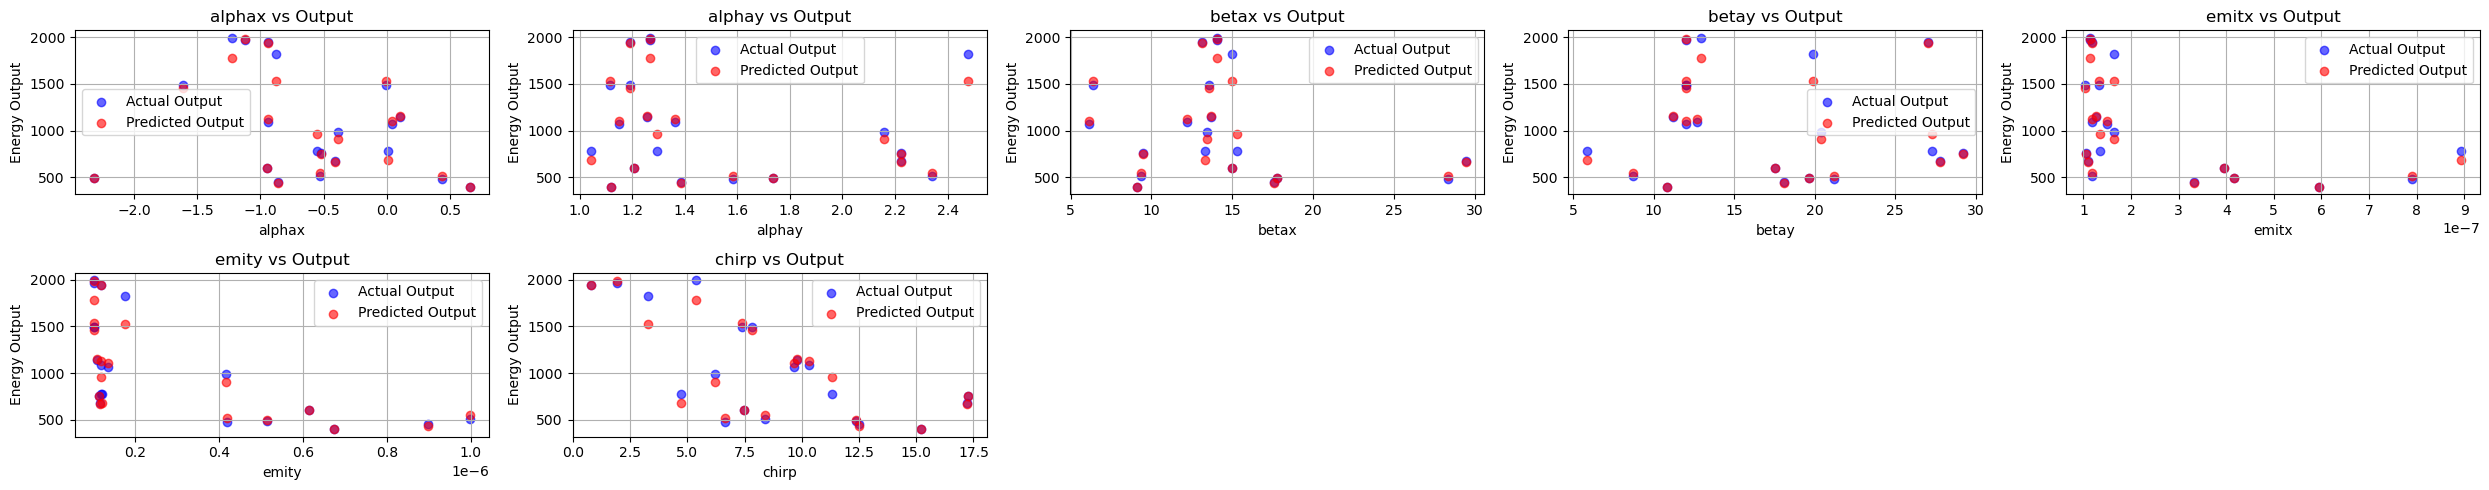

In [19]:
import matplotlib.pyplot as plt
import numpy as np

input_features = ['alphax', 'alphay', 'betax', 'betay', 'emitx', 'emity', 'chirp']
inputs_np = inputs_small.numpy()

n_features = len(input_features)
n_cols = 5  # Number of columns in subplot grid
n_rows = (n_features + n_cols - 1) // n_cols  # Automatically determine number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5))

# Flatten axes in case it's 2D
axes = axes.flatten()

for i, feature_name in enumerate(input_features):
    ax = axes[i]
    ax.scatter(inputs_np[:, i], outputs_small_np[:, 0], color='blue', alpha=0.6, label='Actual Output')
    ax.scatter(inputs_np[:, i], predictions_np[:, 0], color='red', alpha=0.6, label='Predicted Output')
    ax.set_xlabel(feature_name)
    ax.set_ylabel('Energy Output')
    ax.set_title(f'{feature_name} vs Output')
    ax.grid(True)
    ax.legend()

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [131]:
import torch.nn.functional as F
# load example data and calculate predictions
inputs_small = torch.load("./info/test_model_inputs.pt")
inputs_small = inputs_small.double()
outputs_small = torch.load("./info/test_model_outputs.pt")
with torch.no_grad():
    predictions = transformed_model(inputs_small)

predictions_np = predictions.numpy()
outputs_small_np = outputs_small.numpy()


energy_min = outputs_small_np[:, 0].min()
energy_max = outputs_small_np[:, 0].max()


# Plot predictions vs actual outputs
plt.figure(figsize=(15, 6))
plt.subplot(141)
plt.scatter(outputs_small_np[:,0], predictions_np[:,0], color='blue', alpha=0.6, label='Predictions vs Actual')
plt.plot([energy_min, energy_max ], [energy_min, energy_max ], 'r--', lw=2, label='Ideal Prediction')

plt.xlabel('Actual Outputs (Energy)')
plt.ylabel('Predicted Outputs (Energy)')
plt.title('Predictions vs Actual Outputs')
plt.legend()
plt.grid(True)

#plt.xlim([0, 200])

#plt.ylim([0, 200])

bandwidth_min = outputs_small_np[:, 1].min()
bandwidth_max = outputs_small_np[:, 1].max()

plt.subplot(142)
plt.scatter(outputs_small_np[:,1], predictions_np[:,1], color='blue', alpha=0.6, label='Predictions vs Actual')
plt.plot([bandwidth_min, bandwidth_max], [bandwidth_min, bandwidth_max], 'r--', lw=2, label='Ideal Prediction')


plt.xlabel('Actual Outputs (Bandwidth, eV)')
plt.ylabel('Predicted Outputs (Bandwidth, eV) ')
plt.title('Predictions vs Actual Outputs')
plt.legend()

#plt.xlim([0, 150])

#plt.ylim([0, 200])
plt.grid(True)




intensity_min = outputs_small_np[:, 2].min()
intensity_max = outputs_small_np[:, 2].max()


plt.subplot(143)
plt.scatter(outputs_small_np[:,2], predictions_np[:,2], color='blue', alpha=0.6, label='Predictions vs Actual')
plt.plot([intensity_min, intensity_max], [intensity_min, intensity_max], 'r--', lw=2, label='Ideal Prediction')

plt.xlabel('Actual Outputs (Peak Intensity)')
plt.ylabel('Predicted Outputs (Peak Intensity)')
plt.title('Predictions vs Actual Outputs')
plt.legend()

plt.grid(True)

freq_min = outputs_small_np[:, 3].min()
freq_max = outputs_small_np[:, 3].max()


plt.subplot(144)
plt.scatter(outputs_small_np[:,3], predictions_np[:,3], color='blue', alpha=0.6, label='Predictions vs Actual')
plt.plot([freq_min, freq_max], [freq_min, freq_max], 'r--', lw=2, label='Ideal Prediction')

plt.xlabel('Actual Outputs (Central Frequency, eV)')
plt.ylabel('Predicted Outputs (Central Frequency, eV)')
plt.title('Predictions vs Actual Outputs')
plt.legend()

plt.grid(True)


#x1=350
#y1=400
#plt.ylim([x1, y1])
#plt.xlim([x1, y1])

# Show the plot
plt.tight_layout()
plt.show()

len(outputs_small_np[:,0])


/lscratch/jmorgan/tmp/ipykernel_1511367/1917013281.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  inputs_small = torch.load("./info/test_model_inputs.pt")


FileNotFoundError: [Errno 2] No such file or directory: './info/test_model_inputs.pt'

In [ ]:
input_features = ['alphax', 'alphay', 'betax', 'betay', 'emitx', 'emity', 'taper']
inputs_np = inputs_small.numpy()

# Create subplots: One row of subplots with Input vs Output and Prediction for each input feature
n_features = len(input_features)
fig, axes = plt.subplots(1, n_features, figsize=(25, 4))

# Plot Input vs Actual Output and Predicted Output on the same plot for each feature
for i, feature_name in enumerate(input_features):
    # Scatter actual outputs
    axes[i].scatter(inputs_np[:, i], outputs_small_np[:,0], color='blue', alpha=0.6, label='Actual Output')
    
    # Scatter predicted outputs
    axes[i].scatter(inputs_np[:, i], predictions_np[:,0], color='red', alpha=0.6, label='Predicted Output')
    
    # Labels and title
    axes[i].set_xlabel(feature_name.capitalize())
    axes[i].set_ylabel('Energy Output')
    axes[i].set_title(f'{feature_name.capitalize()} vs Output')
    axes[i].grid(True)
    
    # Add a legend
    axes[i].legend()

# Adjust layout
plt.tight_layout()